In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop_words = set(nltk.corpus.stopwords.words('spanish'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jayka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
def preprocesar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r'[^a-záéíóúñ\s]', '', texto)
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    return palabras

In [9]:
df = pd.read_csv('DATASET.csv')

In [10]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['hora'] = df['fecha'].dt.hour


1. Análisis de relación entre calificación y sentimiento:

Palabras más frecuentes por sentimiento:

NEGATIVO:
detalles: 46
menores: 46
espectacular: 45
excepto: 45
mal: 35
arroz: 30
saltado: 26
tacu: 26
ceviche: 25
atención: 25

POSITIVO:
tacu: 82
sabor: 72
lomo: 69
saltado: 65
ceviche: 62
arroz: 59
increíble: 51
dudar: 49
espectacular: 48
excepto: 48

NEUTRO:
bien: 71
precio: 47
podría: 47
tacu: 46
experiencia: 44
arroz: 39
ceviche: 38
saltado: 37
lomo: 33
mal: 28


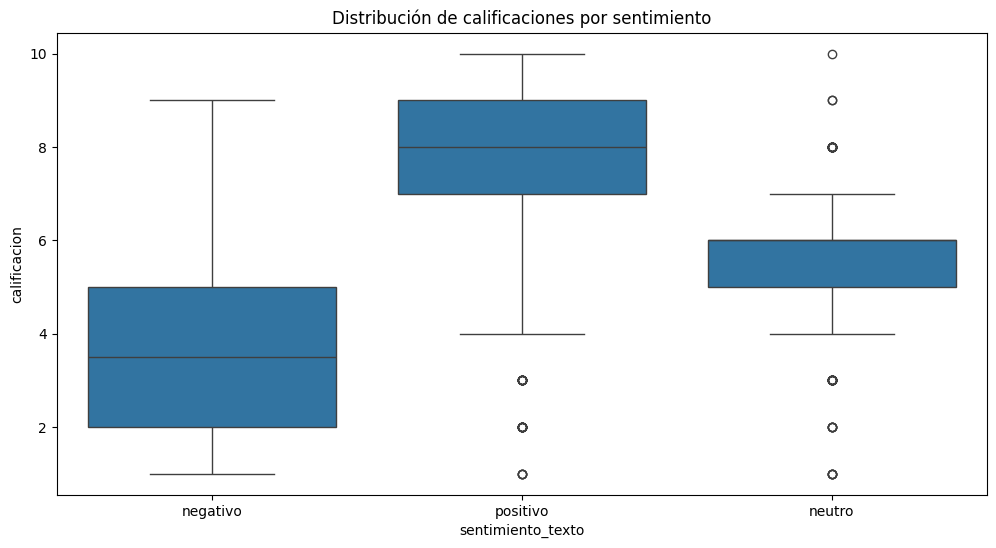

In [11]:
# 1. Análisis de relación entre calificación y sentimiento
def analizar_sentimiento_calificacion():
    print("\n1. Análisis de relación entre calificación y sentimiento:")
    
    df['tokens'] = df['comentario'].apply(preprocesar_texto)
    df['texto_procesado'] = df['tokens'].apply(lambda x: ' '.join(x))
    
    sentiment_words = {}
    for sentiment in df['sentimiento_texto'].unique():
        words = ' '.join(df[df['sentimiento_texto'] == sentiment]['texto_procesado']).split()
        sentiment_words[sentiment] = Counter(words).most_common(10)
    
    print("\nPalabras más frecuentes por sentimiento:")
    for sentiment, words in sentiment_words.items():
        print(f"\n{sentiment.upper()}:")
        for word, count in words:
            print(f"{word}: {count}")
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='sentimiento_texto', y='calificacion', data=df)
    plt.title('Distribución de calificaciones por sentimiento')
    plt.show()

analizar_sentimiento_calificacion()

In [12]:
def analizar_contradicciones():
    # Detectar patrones de ironía
    patrones_ironia = [
        r"excelente.*pero",
        r"perfecto.*salvo",
        r"genial.*dicen",
        r"espectacular.*excepto"
    ]
    
    def detectar_ironia(texto):
        return any(re.search(pattern, texto.lower()) for pattern in patrones_ironia)
    
    df['es_ironico'] = df['comentario'].apply(detectar_ironia)
    
    # Identificar contradicciones usando procesamiento de texto
    contradicciones = df[
        ((df['calificacion'] >= 8) & (df['sentimiento_texto'] == 'negativo')) |
        ((df['calificacion'] <= 3) & (df['sentimiento_texto'] == 'positivo'))
    ].copy()
    
    print("\nAnálisis de contradicciones con procesamiento de texto:")
    for _, row in contradicciones.iterrows():
        tokens = row['tokens']
        print(f"\nCalificación: {row['calificacion']}")
        print(f"Sentimiento: {row['sentimiento_texto']}")
        print(f"Tokens relevantes: {', '.join(tokens[:10])}")
        print(f"Comentario original: {row['comentario']}")
        print("-" * 50)

analizar_contradicciones()
    


Análisis de contradicciones con procesamiento de texto:

Calificación: 8
Sentimiento: negativo
Tokens relevantes: espectacular, excepto, detalles, menores, anticuchos, llegó, frío, sabor
Comentario original: Todo espectacular, excepto algunos detalles menores. El Anticuchos llegó frío y sin sabor.
--------------------------------------------------

Calificación: 3
Sentimiento: positivo
Tokens relevantes: excelente, si, buscabas, ají, gallina, aire
Comentario original: Excelente si lo que buscabas era Ají de gallina con aire.
--------------------------------------------------

Calificación: 3
Sentimiento: positivo
Tokens relevantes: perfecto, salvo, detalles, menores, ceviche, mixto, crudo
Comentario original: Todo perfecto… salvo detalles menores como el Ceviche mixto crudo.
--------------------------------------------------

Calificación: 2
Sentimiento: positivo
Tokens relevantes: fin, aprendieron, servir, caliente, lomo, saltado
Comentario original: Por fin aprendieron a servir cali

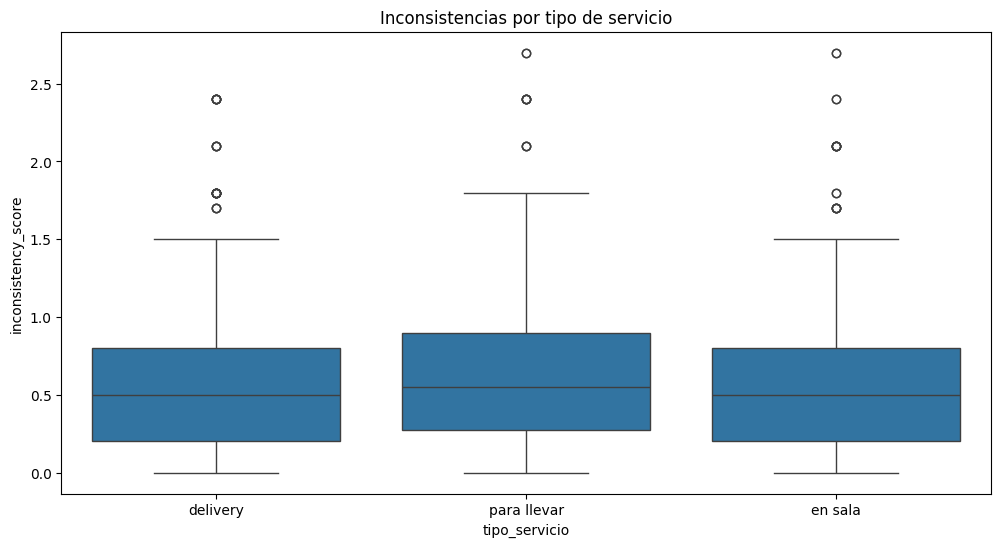


Puntaje de inconsistencia por tipo de servicio:
                   mean  count
tipo_servicio                 
delivery       0.606287    334
en sala        0.606051    314
para llevar    0.647443    352


In [13]:
def calculate_inconsistency(row):
    sentiment_score = {'positivo': 3, 'neutro': 2, 'negativo': 1}
    normalized_rating = row['calificacion'] / 10 * 3
    return abs(normalized_rating - sentiment_score[row['sentimiento_texto']])

df['inconsistency_score'] = df.apply(calculate_inconsistency, axis=1)
    
plt.figure(figsize=(12, 6))
sns.boxplot(x='tipo_servicio', y='inconsistency_score', data=df)
plt.title('Inconsistencias por tipo de servicio')
plt.show()
    
service_analysis = df.groupby('tipo_servicio')['inconsistency_score'].agg(['mean', 'count'])
print("\nPuntaje de inconsistencia por tipo de servicio:")
print(service_analysis)


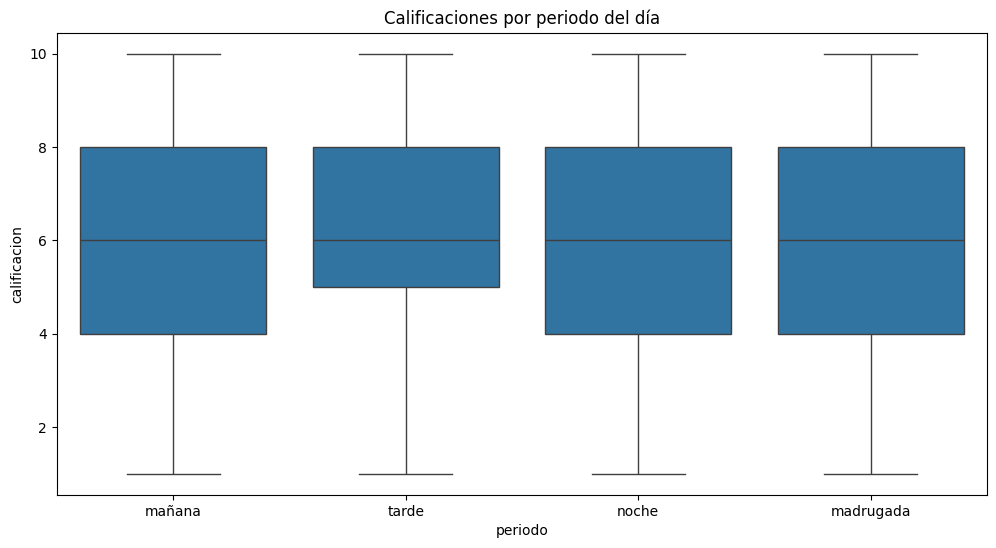


Análisis por periodo del día:
           calificacion  inconsistency_score
periodo                                     
mañana         5.981395             0.660465
tarde          6.252747             0.561538
noche          6.114286             0.625397
madrugada      6.091371             0.651777


C:\Users\jayka\AppData\Local\Temp\ipykernel_6904\3997828972.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_analysis = df.groupby('periodo').agg({


In [14]:
# 4. Influencia del horario
df['periodo'] = pd.cut(df['hora'], 
                bins=[0, 11, 15, 19, 23],
                labels=['mañana', 'tarde', 'noche', 'madrugada'])
    

plt.figure(figsize=(12, 6))
sns.boxplot(x='periodo', y='calificacion', data=df)
plt.title('Calificaciones por periodo del día')
plt.show()
    
time_analysis = df.groupby('periodo').agg({
        'calificacion': 'mean',
        'inconsistency_score': 'mean'
    })
    
print("\nAnálisis por periodo del día:")
print(time_analysis)

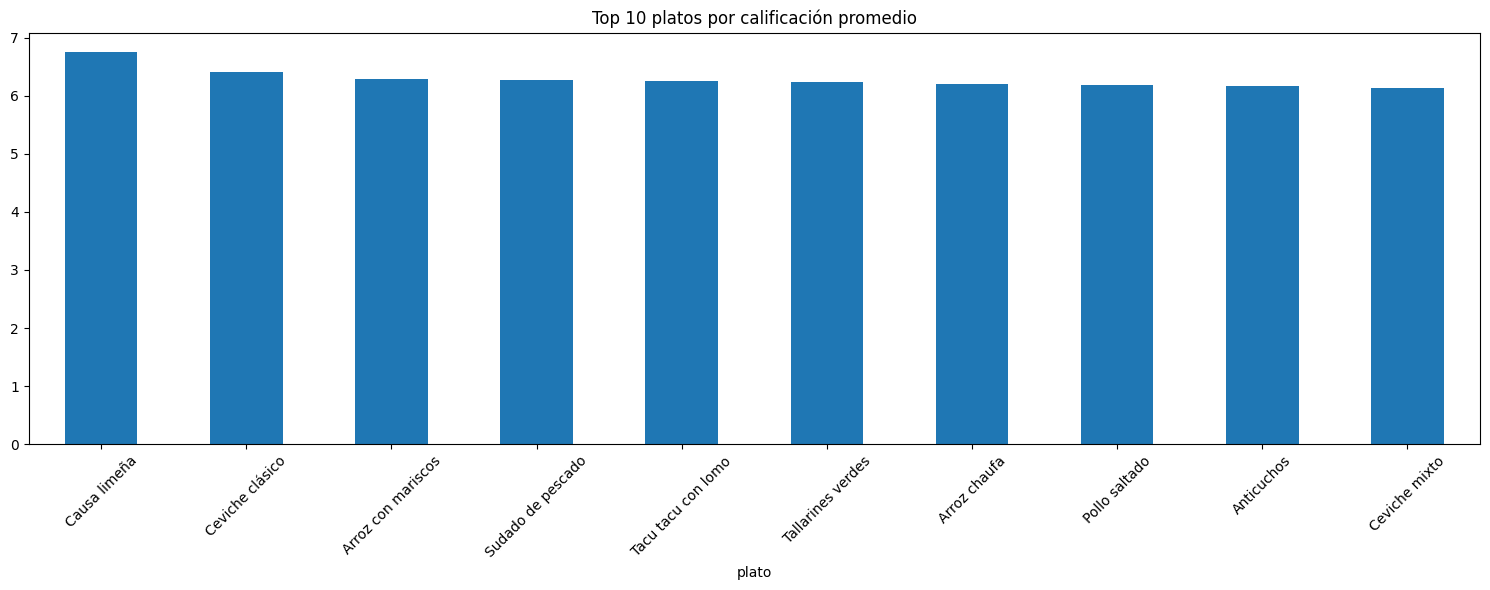


Análisis por plato:
                       calificacion  inconsistency_score sentimiento_texto
plato                                                                     
Ají de gallina                 5.62                 0.70          positivo
Anticuchos                     6.16                 0.58          positivo
Arroz chaufa                   6.20                 0.58          positivo
Arroz con mariscos             6.29                 0.59          positivo
Causa limeña                   6.75                 0.57          positivo
Ceviche clásico                6.41                 0.63          positivo
Ceviche mixto                  6.13                 0.60          positivo
Chicharrón de calamar          5.49                 0.68          positivo
Lomo saltado                   6.04                 0.69          positivo
Parihuela                      6.00                 0.66          positivo
Pollo saltado                  6.18                 0.66          positivo
Seco

In [15]:
# 5. Influencia del plato
plt.figure(figsize=(15, 6))
dish_ratings = df.groupby('plato')['calificacion'].mean().sort_values(ascending=False)
dish_ratings.head(10).plot(kind='bar')
plt.title('Top 10 platos por calificación promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    
dish_analysis = df.groupby('plato').agg({
        'calificacion': 'mean',
        'inconsistency_score': 'mean',
        'sentimiento_texto': lambda x: x.value_counts().index[0]
    }).round(2)
    
print("\nAnálisis por plato:")
print(dish_analysis)

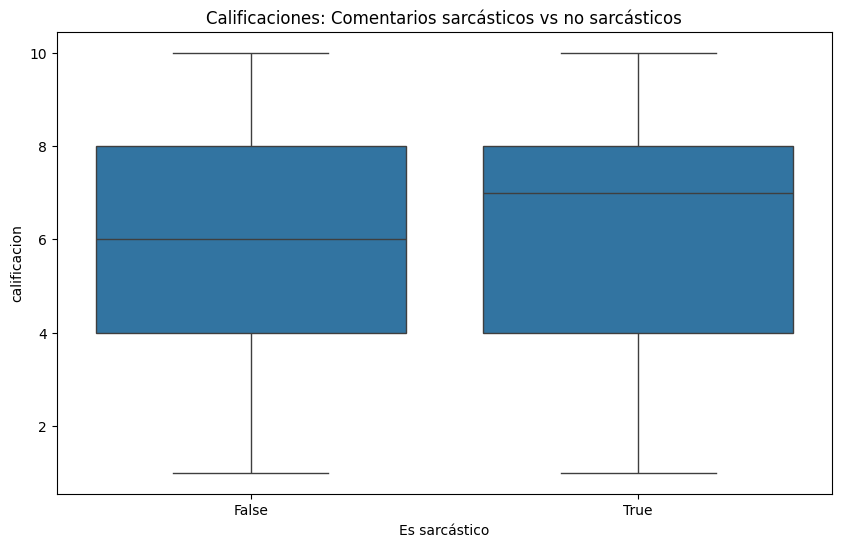


Comentarios potencialmente sarcásticos:

Comentario: Todo espectacular, excepto algunos detalles menores. El Anticuchos llegó frío y sin sabor.
Calificación: 8
Sentimiento: negativo

Comentario: Espectacular,  excepto  el  Ají  de  gallina,  la  cuenta  y  la  espera.
Calificación: 7
Sentimiento: positivo

Comentario: Espectacular, excepto el Chicharrón de calamar, la cuenta y la espera.
Calificación: 8
Sentimiento: positivo

Comentario: Todo perfecto… salvo detalles menores como el Chicharrón de calamar crudo.
Calificación: 4
Sentimiento: positivo

Comentario: Espectacular, excepto el Arroz con mariscos, la cuenta y la espera.
Calificación: 8
Sentimiento: positivo


In [16]:
# 6. Identificar sarcasmo
sarcasm_patterns = [
        r"excelente.*pero",
        r"perfecto.*salvo",
        r"genial.*dicen",
        r"espectacular.*excepto"
    ]
    
def is_sarcastic(text):
    return any(re.search(pattern, text.lower()) for pattern in sarcasm_patterns)
    
df['is_sarcastic'] = df['comentario'].apply(is_sarcastic)
    
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_sarcastic', y='calificacion', data=df)
plt.title('Calificaciones: Comentarios sarcásticos vs no sarcásticos')
plt.xlabel('Es sarcástico')
plt.show()
    
sarcastic_comments = df[df['is_sarcastic']]
print("\nComentarios potencialmente sarcásticos:")
for _, row in sarcastic_comments.head().iterrows():
    print(f"\nComentario: {row['comentario']}")
    print(f"Calificación: {row['calificacion']}")
    print(f"Sentimiento: {row['sentimiento_texto']}")



Ejemplos de ironía mal clasificados:

Tabla de clasificaciones erróneas con análisis lingüístico:
                                           comentario sentimiento_texto clasificacion_automatica                                               tokens
Todo espectacular, excepto algunos detalles menore...          negativo                   neutro espectacular, excepto, detalles, menores, anticuchos
Excelente si lo que buscabas era Ceviche clásico c...          negativo                   neutro            excelente, si, buscabas, ceviche, clásico
Espectacular,  excepto  el  Ají  de  gallina,  la ...          positivo                   neutro          espectacular, excepto, ají, gallina, cuenta
Superó  mis  expectativas;  el  Causa  limeña  est...          positivo                   neutro       superó, expectativas, causa, limeña, increíble
                Nada rescatable del Pollo saltado....          negativo                   neutro                           rescatable, pollo, saltado


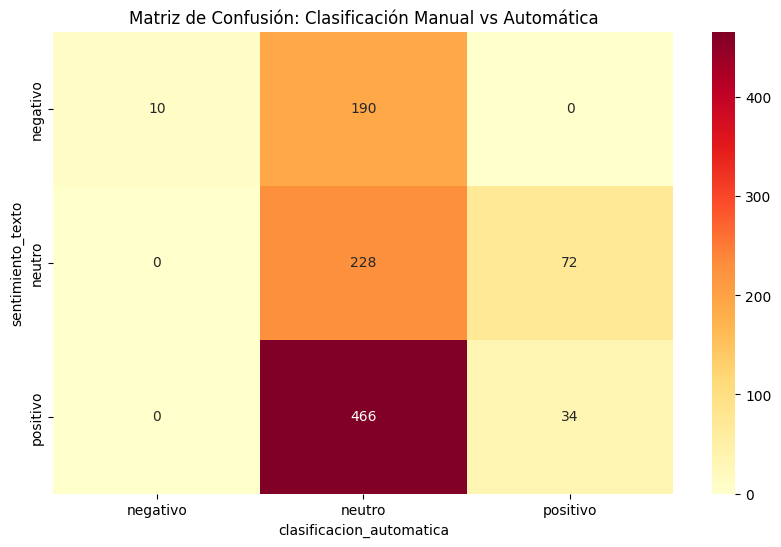

In [26]:
def analizar_ironia():
    def obtener_sentimiento_automatico(texto):
        return TextBlob(texto).sentiment.polarity
    
    df['sentimiento_automatico'] = df['comentario'].apply(obtener_sentimiento_automatico)
    df['clasificacion_automatica'] = df['sentimiento_automatico'].apply(
        lambda x: 'positivo' if x > 0.1 else 'negativo' if x < -0.1 else 'neutro'
    )
    
    mal_clasificados = df[df['clasificacion_automatica'] != df['sentimiento_texto']].copy()
    
    print("\nEjemplos de ironía mal clasificados:")
    ejemplos_df = mal_clasificados.head()[['comentario', 'sentimiento_texto', 'clasificacion_automatica', 'tokens']].copy()
    ejemplos_df['comentario'] = ejemplos_df['comentario'].str[:50] + '...'
    ejemplos_df['tokens'] = ejemplos_df['tokens'].apply(lambda x: ', '.join(x[:5]))
    print("\nTabla de clasificaciones erróneas con análisis lingüístico:")
    print(ejemplos_df.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    confusion_matrix = pd.crosstab(df['sentimiento_texto'], df['clasificacion_automatica'])
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Matriz de Confusión: Clasificación Manual vs Automática')
    plt.show()


analizar_ironia()